In [44]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

1. Załadowanie danych.

In [45]:
data = pd.read_csv('katowice_full.csv')

In [46]:
len(data)

2000

In [47]:
data.head()

,url,title,price,location,area_m2,rooms,floor,market_type,year_built,finish,heating,rent,ownership,available_from,advertiser_type,extras,price_per_m2,elevator,building_material,window_type,building_type,energy_certificate,security_features
0,https://www.otodom.pl/pl/oferta/rezerwacja-mie...,Rezerwacja !!Mieszkanie po remoncie 3 pokoje 50m2,547 000 zł,"ul.Sowińskiego 33 osiedle Paderewskiego, Osied...",49.50,3,5/10,wtórny,brak informacji,do zamieszkania,miejskie,663 zł,spółdzielcze wł. prawo do lokalu,brak informacji,prywatny,"balkon, piwnica, oddzielna kuchnia",11051,tak,wielka płyta,plastikowe,blok,W trakcie realizacji / Zwolnione,brak informacji
1,https://www.otodom.pl/pl/oferta/apartament-20-...,"Apartament 20 piętro, NOWE, super widok, hala.",499 000 zł,"ul. Zabrska, Śródmieście, Katowice, śląskie",36.13,2,> 10/26,pierwotny,2024,do wykończenia,miejskie,400 zł,pełna własność,brak informacji,prywatny,garaż/miejsce parkingowe,13811,tak,żelbet,aluminiowe,apartamentowiec,A+,monitoring / ochrona
2,https://www.otodom.pl/pl/oferta/mieszkanie-3-p...,MIESZKANIE 3 POKOJE 48 m2 ulica Kubiny,473 000 zł,"ul. ks. bp. Teodora Kubiny, Śródmieście, Katow...",48.00,3,2/4,wtórny,1970,do zamieszkania,miejskie,800 zł,spółdzielcze wł. prawo do lokalu,2025-03-23,prywatny,piwnica,9854,nie,cegła,plastikowe,blok,A,brak informacji
3,https://www.otodom.pl/pl/oferta/ville-garden-m...,Ville Garden | mieszkanie 3-pok. | B.34,1 753 312 zł,"ul. Studencka, Ligota-Panewniki, Katowice, ślą...",99.62,3,4/4,pierwotny,2026,do wykończenia,inne,brak informacji,pełna własność,2026-06-30,deweloper,"balkon, garaż/miejsce parkingowe, pom. użytkowe",17600,tak,brak informacji,plastikowe,blok,brak informacji,teren zamknięty
4,https://www.otodom.pl/pl/oferta/prado-katowice...,Prado Katowice | mieszkanie 4-pok. | A3_0_01,938 790 zł,"ul. Wojska Polskiego, Piotrowice-Ochojec, Kato...",76.95,4,parter/2,pierwotny,2026,do wykończenia,brak informacji,brak informacji,pełna własność,2026-03-01,deweloper,"taras, ogródek, garaż/miejsce parkingowe, pom....",12200,nie,brak informacji,plastikowe,blok,brak informacji,brak informacji


In [48]:
print((data == "brak informacji").sum())

url                      0
title                    0
price                  183
location                 0
area_m2                  0
rooms                    0
floor                   11
market_type              0
year_built             600
finish                 208
heating                518
rent                  1017
ownership              347
available_from        1259
advertiser_type          0
extras                 177
price_per_m2           183
elevator                 0
building_material     1101
window_type            647
building_type          339
energy_certificate    1715
security_features     1185
dtype: int64


In [49]:
# Zamieniamy "brak informacji" na NaN
data.replace("brak informacji", np.nan, inplace=True)


In [50]:
null_counts = data.isna().sum()
null_percent = (null_counts / len(data) * 100).round(1)

# Tworzymy zbiorcze zestawienie
null_summary = pd.DataFrame({
    "Liczba brakujących wartości": null_counts,
    "Udział procentowy braków": null_percent
}).sort_values(by="Udział procentowy braków", ascending=False)

null_summary

,Liczba brakujących wartości,Udział procentowy braków
energy_certificate,1715,85.8
available_from,1259,63.0
security_features,1185,59.2
building_material,1101,55.0
rent,1017,50.8
window_type,648,32.4
year_built,600,30.0
heating,527,26.4
ownership,347,17.3
building_type,339,17.0


In [51]:
cols_to_drop = [
    "energy_certificate", "available_from", "security_features",
    "building_material", "rent", "url", "title", "price_per_m2", "window_type"
]

data.drop(columns=cols_to_drop, inplace=True)

In [52]:
data = data[~data["price"].isna()]

2. Przetworzenie kolumn z ceną, rozbicie na piątra i ilość pięter w bloku oraz przekształcenie roku budowy.

In [53]:
# Funkcja czyszcząca ceny
def clean_price(val):
    if isinstance(val, str):
        val = val.replace("zł", "").replace(" ", "").replace(",", ".")
        try:
            return float(val)
        except:
            return np.nan
    return val if isinstance(val, (int, float)) else np.nan

# Zastosowanie do kolumn
data["price"] = data["price"].apply(clean_price)

# Przetwarzanie piętra – floor_num i max_floor
def extract_floor_info(floor_val):
    if pd.isna(floor_val):
        return (np.nan, np.nan)
    if isinstance(floor_val, str):
        floor_val = floor_val.lower().strip()
        if "parter" in floor_val:
            floor = 0
        else:
            floor_match = re.search(r"(\d+)", floor_val)
            floor = int(floor_match.group(1)) if floor_match else np.nan
        max_floor_match = re.search(r"/(\d+)", floor_val)
        max_floor = int(max_floor_match.group(1)) if max_floor_match else np.nan
        return (floor, max_floor)
    return (np.nan, np.nan)

data[["floor_num", "max_floor"]] = data["floor"].apply(lambda x: pd.Series(extract_floor_info(x)))
data.drop("floor", axis=1, inplace=True)

# Konwersja roku budowy do liczby
def clean_year(val):
    if pd.isna(val):
        return np.nan
    if isinstance(val, str):
        match = re.search(r"(19\d{2}|20\d{2})", val)
        return int(match.group(1)) if match else np.nan
    return val

data["year_built"] = data["year_built"].apply(clean_year)

6. Uzupełnienie brakujących wartości medianą oraz 'unknown'.

In [54]:
num_fill_cols = ["year_built", "floor_num", "max_floor"]
for col in num_fill_cols:
    data[col] = data[col].fillna(data[col].median())

In [55]:
cat_fill_cols = ["heating", "ownership", "building_type", "finish", "extras"]
for col in cat_fill_cols:
    data[col] = data[col].fillna("unknown")


7. Wyciągnięcie nazwy osiedla z lokalizacji.

In [56]:
def extract_district_from_location(loc):
    if pd.isna(loc):
        return "Unknown"
    
    loc = loc.lower().replace("ul.", "").strip()
    parts = [part.strip() for part in loc.split(",")]
    parts = [p for p in parts if p not in ["katowice", "śląskie"]]

    if parts:
        return parts[-1].title()
    else:
        return "Unknown"

data["district"] = data["location"].apply(extract_district_from_location)

In [57]:
print("\nWszystkie dzielnice:")
print(data["district"].value_counts())



Wszystkie dzielnice:
district
Śródmieście                        348
Osiedle Paderewskiego-Muchowiec    187
Wełnowiec-Józefowiec               153
Ligota-Panewniki                   131
Brynów-Osiedle Zgrzebnioka         123
Koszutka                           120
Bogucice                           108
Dąb                                108
Piotrowice-Ochojec                  97
Osiedle Tysiąclecia                 87
Załęska Hałda-Brynów                55
Kostuchna                           53
Szopienice-Burowiec                 49
Janów-Nikiszowiec                   44
Giszowiec                           44
Osiedle Witosa                      25
Zawodzie                            23
Załęże                              18
Siemianowice Śląskie                10
Dąbrówka Mała                       10
Murcki                               9
Mysłowice                            6
Zarzecze                             3
Podlesie                             3
Chorzów                          

In [58]:
from geopy.distance import geodesic

# Współrzędne centrum Katowic (Śródmieście)
centrum_katowic = (50.2625, 19.0217)

# Słownik z dzielnicami i ich współrzędnymi
dzielnice = {
    "Śródmieście": (50.2625, 19.0217),
    "Osiedle Paderewskiego-Muchowiec": (50.2550, 19.0270),
    "Wełnowiec-Józefowiec": (50.2770, 19.0050),
    "Ligota-Panewniki": (50.2380, 18.9800),
    "Brynów-Osiedle Zgrzebnioka": (50.2450, 19.0000),
    "Koszutka": (50.2700, 19.0200),
    "Bogucice": (50.2700, 19.0350),
    "Dąb": (50.2700, 19.0000),
    "Piotrowice-Ochojec": (50.2200, 18.9700),
    "Osiedle Tysiąclecia": (50.2750, 18.9900),
    "Załęska Hałda-Brynów": (50.2500, 18.9950),
    "Kostuchna": (50.2100, 18.9600),
    "Szopienice-Burowiec": (50.2600, 19.0500),
    "Janów-Nikiszowiec": (50.2450, 19.0500),
    "Giszowiec": (50.2300, 19.0500),
    "Osiedle Witosa": (50.2600, 18.9900),
    "Zawodzie": (50.2600, 19.0400),
    "Załęże": (50.2650, 19.0000),
    "Dąbrówka Mała": (50.2800, 19.0300),
    "Murcki": (50.2200, 19.0600),
    "Zarzecze": (50.2000, 18.9500),
    "Podlesie": (50.1900, 18.9400),
}

print("Odleglosci od centrum:")

# Obliczanie odległości
for dzielnica, wspolrzedne in dzielnice.items():
    odleglosc = geodesic(centrum_katowic, wspolrzedne).kilometers
    print(f"{dzielnica}: {odleglosc:.2f}")


Odleglosci od centrum:
Śródmieście: 0.00
Osiedle Paderewskiego-Muchowiec: 0.92
Wełnowiec-Józefowiec: 2.00
Ligota-Panewniki: 4.03
Brynów-Osiedle Zgrzebnioka: 2.49
Koszutka: 0.84
Bogucice: 1.26
Dąb: 1.76
Piotrowice-Ochojec: 6.00
Osiedle Tysiąclecia: 2.65
Załęska Hałda-Brynów: 2.36
Kostuchna: 7.31
Szopienice-Burowiec: 2.04
Janów-Nikiszowiec: 2.80
Giszowiec: 4.14
Osiedle Witosa: 2.28
Zawodzie: 1.33
Załęże: 1.57
Dąbrówka Mała: 2.03
Murcki: 5.46
Zarzecze: 8.63
Podlesie: 9.95


In [59]:
print("\nLiczba unikalnych dzielnic:", data["district"].nunique())

print("\n Dzielnice:")
print(data["district"].value_counts().head(25))  

print("\nRzadkie dzielnice (poniżej 10 ogłoszeń):")
print(data["district"].value_counts()[data["district"].value_counts() < 15])



Liczba unikalnych dzielnic: 25

 Dzielnice:
district
Śródmieście                        348
Osiedle Paderewskiego-Muchowiec    187
Wełnowiec-Józefowiec               153
Ligota-Panewniki                   131
Brynów-Osiedle Zgrzebnioka         123
Koszutka                           120
Bogucice                           108
Dąb                                108
Piotrowice-Ochojec                  97
Osiedle Tysiąclecia                 87
Załęska Hałda-Brynów                55
Kostuchna                           53
Szopienice-Burowiec                 49
Janów-Nikiszowiec                   44
Giszowiec                           44
Osiedle Witosa                      25
Zawodzie                            23
Załęże                              18
Siemianowice Śląskie                10
Dąbrówka Mała                       10
Murcki                               9
Mysłowice                            6
Zarzecze                             3
Podlesie                             3
Chorzów   

8. Usunięcie danych nie należących do Katowic.

In [60]:
districts_to_remove = ["Chorzów", "Mysłowice", "Siemianowice Śląskie"]

data = data[~data["district"].isin(districts_to_remove)]

8.1. Zrobienie kolumny z odlegloscią od centrum.

In [61]:
odleglosci = {
    "Śródmieście": 0.00,
    "Osiedle Paderewskiego-Muchowiec": 0.92,
    "Wełnowiec-Józefowiec": 2.00,
    "Ligota-Panewniki": 4.03,
    "Brynów-Osiedle Zgrzebnioka": 2.49,
    "Koszutka": 0.84,
    "Bogucice": 1.26,
    "Dąb": 1.76,
    "Piotrowice-Ochojec": 6.00,
    "Osiedle Tysiąclecia": 2.65,
    "Załęska Hałda-Brynów": 2.36,
    "Kostuchna": 7.31,
    "Szopienice-Burowiec": 2.04,
    "Janów-Nikiszowiec": 2.80,
    "Giszowiec": 4.14,
    "Osiedle Witosa": 2.28,
    "Zawodzie": 1.33,
    "Załęże": 1.57,
    "Dąbrówka Mała": 2.03,
    "Murcki": 5.46,
    "Zarzecze": 8.63,
    "Podlesie": 9.95
}

# Tworzenie nowej kolumny z odległością od centrum
data["distance_from_centre"] = data["district"].map(odleglosci)


In [62]:
print(data[["district", "distance_from_centre"]].drop_duplicates().sort_values("distance_from_centre"))

                            district  distance_from_centre
1                        Śródmieście                  0.00
30                          Koszutka                  0.84
0    Osiedle Paderewskiego-Muchowiec                  0.92
46                          Bogucice                  1.26
66                          Zawodzie                  1.33
100                           Załęże                  1.57
12                               Dąb                  1.76
14              Wełnowiec-Józefowiec                  2.00
272                    Dąbrówka Mała                  2.03
23               Szopienice-Burowiec                  2.04
174                   Osiedle Witosa                  2.28
19              Załęska Hałda-Brynów                  2.36
78        Brynów-Osiedle Zgrzebnioka                  2.49
51               Osiedle Tysiąclecia                  2.65
42                 Janów-Nikiszowiec                  2.80
3                   Ligota-Panewniki                  4.

9. Czyszczenie kolumny z ogrzewaniem. 

In [63]:
# Akceptowane wartości
valid_heating = [
    "miejskie", "gazowe", "elektryczne", "kotłownia", "piece kaflowe", "unknown", "inne"
]

# Czyszczenie kolumny – wszystko inne → 'inne'
data["heating"] = data["heating"].apply(
    lambda x: x if x in valid_heating else "inne"
)

## Wykresy 

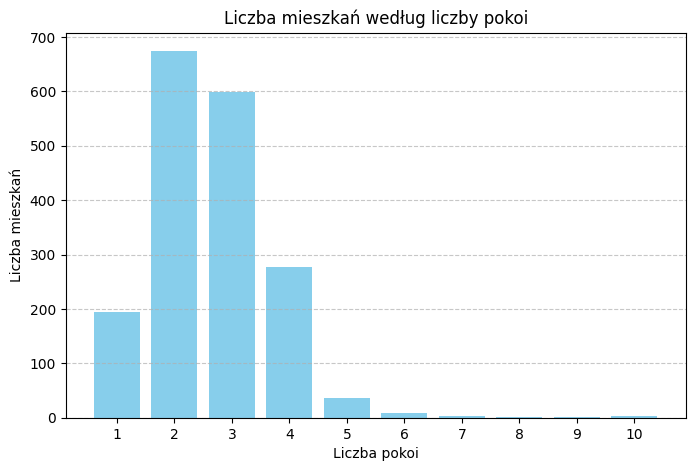

In [ ]:
room_counts = data["rooms"].value_counts().sort_index()

plt.figure(figsize=(8, 5))
plt.bar(room_counts.index, room_counts.values, color="skyblue")
plt.xlabel("Liczba pokoi")
plt.ylabel("Liczba mieszkań")
plt.title("Liczba mieszkań według liczby pokoi")
plt.xticks(room_counts.index)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


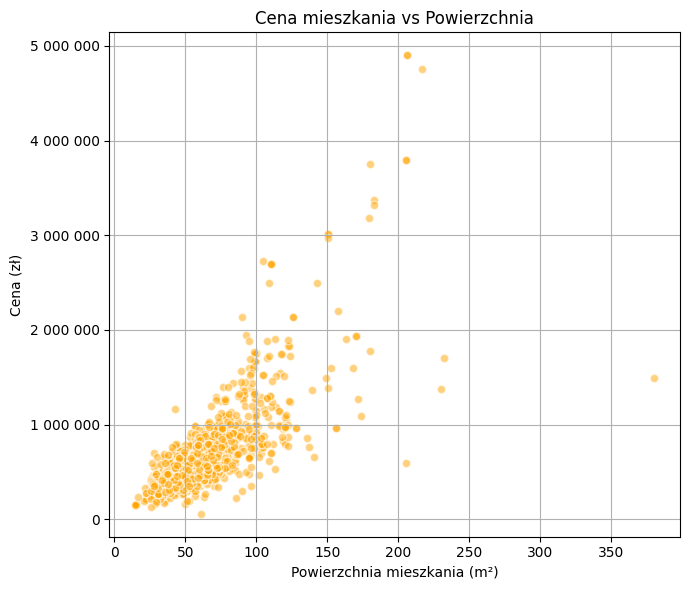

In [ ]:
plt.figure(figsize=(7, 6))
plt.scatter(data["area_m2"], data["price"], alpha=0.5, color="orange", edgecolors="w")

plt.title("Cena mieszkania vs Powierzchnia")
plt.xlabel("Powierzchnia mieszkania (m²)")
plt.ylabel("Cena (zł)")

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(",", " ")))

plt.grid(True)
plt.tight_layout()
plt.show()


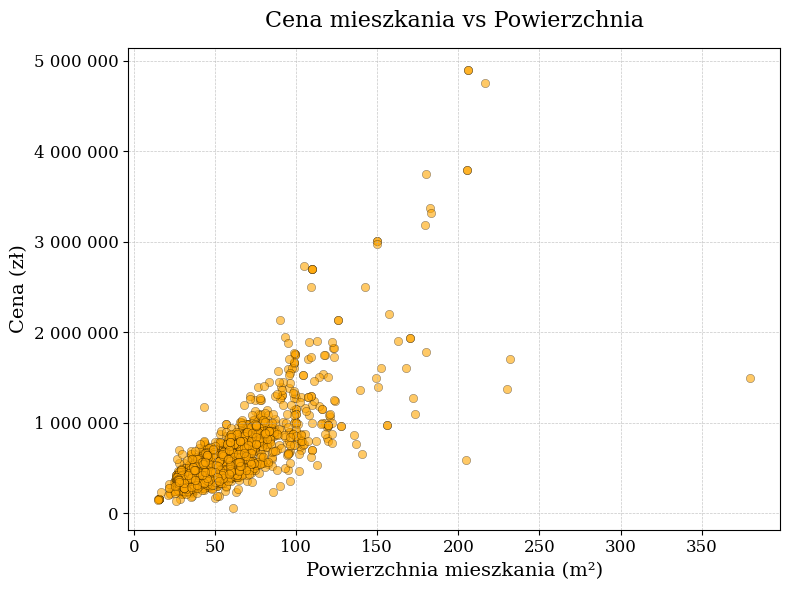

In [ ]:
import matplotlib as mpl

mpl.rcParams['font.family'] = 'DejaVu Serif'
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

plt.figure(figsize=(8, 6))

plt.scatter(
    data["area_m2"], data["price"], 
    alpha=0.6, color="orange", edgecolors="black", linewidth=0.3
)

plt.title("Cena mieszkania vs Powierzchnia", pad=15)
plt.xlabel("Powierzchnia mieszkania (m²)")
plt.ylabel("Cena (zł)")

formatter = ticker.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(",", " "))
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_formatter(formatter)

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()


Połączenie rzadkich wartosci jako inne.

In [66]:
data["building_type"].value_counts()

building_type
blok                815
apartamentowiec     523
unknown             239
kamienica           213
szeregowiec           5
dom wolnostojący      3
Name: count, dtype: int64

In [67]:
data["heating"] = data["heating"].replace({
    "piece kaflowe": "inne",
    "kotłownia": "inne",
    "elektryczne": "inne"
})

In [68]:
data["ownership"] = data["ownership"].replace({
    "udział": "unknown",
    "użytkowanie wieczyste / dzierżawa": "unknown"
})

In [69]:
data["building_type"] = data["building_type"].replace({
    "szeregowiec": "unknown",
    "dom wolnostojący": "unknown"
})

Usunięcie rekordów z błędnymi piętrami.

In [70]:
# konwertowanie do float
data["floor_num"] = pd.to_numeric(data["floor_num"], errors="coerce")

# Zostawiamy tylko realne piętra (np. od 0 do 50)
data = data[(data["floor_num"] >= 0) & (data["floor_num"] <= 50)]


11. ONE HOT ENCODING i czyszczenie extras.

In [71]:
categorical_cols = [
    "market_type", "finish", "heating", "ownership",
    "advertiser_type", "building_type", "elevator"
]

data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# PRZETWARZANIE `extras` jako zestaw binarnych cech
extras_features = [
    "balkon", "taras", "piwnica", "garaż/miejsce parkingowe",
    "pom. użytkowe", "ogródek", "oddzielna kuchnia"
]

for feature in extras_features:
    colname = f"extra_{feature.replace(' ', '_')}"
    data_encoded[colname] = data["extras"].str.contains(feature, na=False)

# Usuwamy oryginalną kolumnę extras, location i district
data_encoded.drop(columns=["extras", "location", "district"], inplace=True)

In [72]:
pd.set_option('display.max_columns', None)

print(data_encoded.columns)

len(data_encoded.columns)

Index(['price', 'area_m2', 'rooms', 'year_built', 'floor_num', 'max_floor',
       'distance_from_centre', 'market_type_wtórny', 'finish_do wykończenia',
       'finish_do zamieszkania', 'finish_unknown', 'heating_inne',
       'heating_miejskie', 'heating_unknown',
       'ownership_spółdzielcze wł. prawo do lokalu', 'ownership_unknown',
       'advertiser_type_deweloper', 'advertiser_type_prywatny',
       'building_type_blok', 'building_type_kamienica',
       'building_type_unknown', 'elevator_tak', 'extra_balkon', 'extra_taras',
       'extra_piwnica', 'extra_garaż/miejsce_parkingowe',
       'extra_pom._użytkowe', 'extra_ogródek', 'extra_oddzielna_kuchnia'],
      dtype='object')


29

12. Wykresy po one-hot encoding.

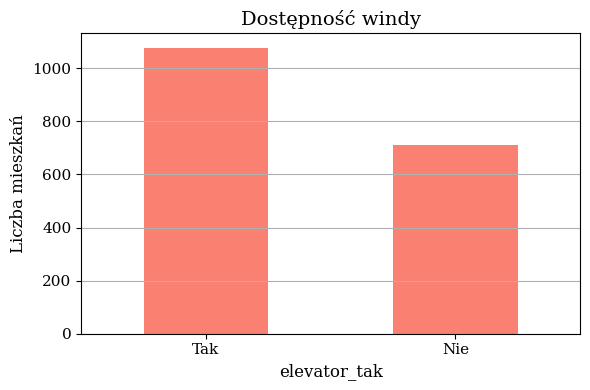

In [82]:
plt.figure(figsize=(6, 4))
data_encoded["elevator_tak"].value_counts().plot(kind="bar", color="salmon")
plt.title("Dostępność windy")
plt.xticks([0, 1], ['Tak', 'Nie'], rotation=0)
plt.ylabel("Liczba mieszkań")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


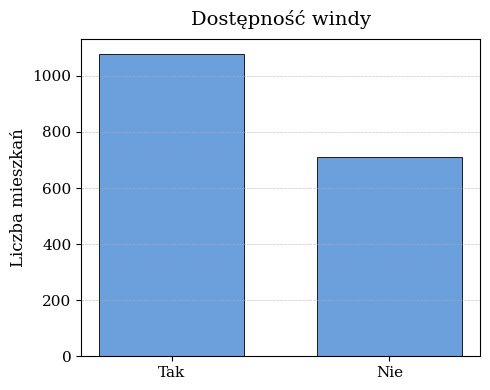

In [ ]:
mpl.rcParams['font.family'] = 'DejaVu Serif'
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 11
mpl.rcParams['ytick.labelsize'] = 11

counts = data_encoded["elevator_tak"].value_counts().reindex([1, 0])
labels = ['Tak', 'Nie']
bar_color = '#6CA0DC'

positions = [0.4, 0.7]  # mniejsze rozstawienie
bar_width = 0.2        # węższe niż domyślnie

plt.figure(figsize=(5, 4))
bars = plt.bar(positions, counts.values, width=bar_width, color=bar_color, edgecolor="black", linewidth=0.6)

plt.xticks(positions, labels)

plt.title("Dostępność windy", pad=10)
plt.ylabel("Liczba mieszkań")
plt.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()


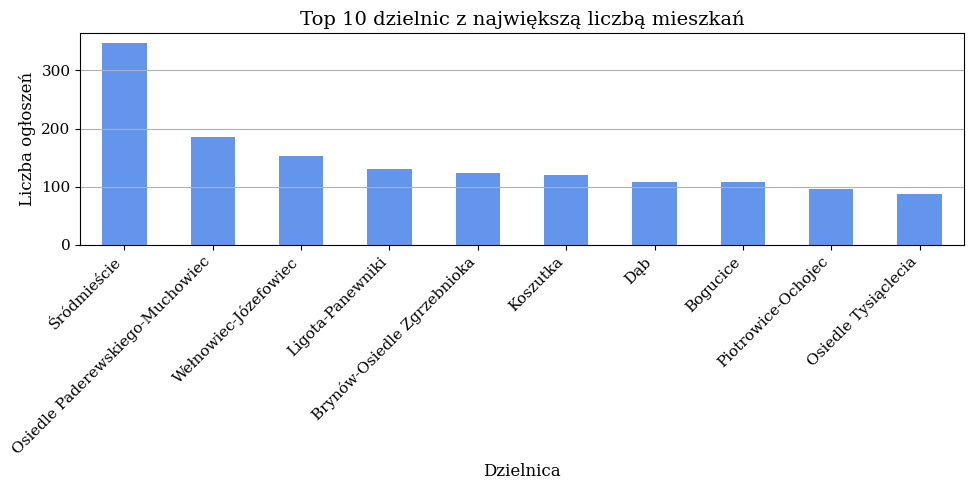

In [87]:
top_districts = data["district"].value_counts().nlargest(10)

plt.figure(figsize=(10, 5))
top_districts.plot(kind="bar", color="cornflowerblue")
plt.title("Top 10 dzielnic z największą liczbą mieszkań")
plt.xlabel("Dzielnica")
plt.ylabel("Liczba ogłoszeń")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


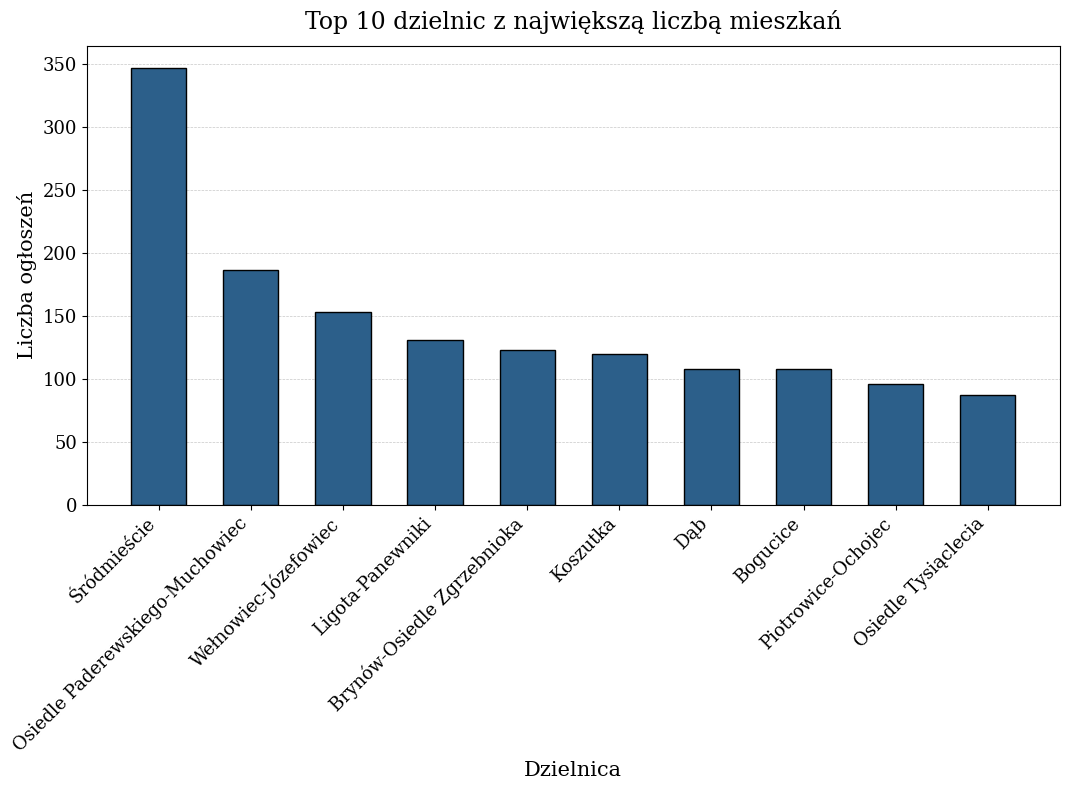

In [ ]:
mpl.rcParams['font.family'] = 'DejaVu Serif'
mpl.rcParams['axes.titlesize'] = 17     
mpl.rcParams['axes.labelsize'] = 15     
mpl.rcParams['xtick.labelsize'] = 13    
mpl.rcParams['ytick.labelsize'] = 13    

top_districts = data["district"].value_counts().nlargest(10)

plt.figure(figsize=(11, 8))
bars = plt.bar(
    top_districts.index, top_districts.values,
    color='#2C5F8A', edgecolor='black', width=0.6
)

# Siatka i krok co 50
plt.gca().set_axisbelow(True)
max_val = top_districts.max()
plt.yticks(np.arange(0, max_val + 50, 50))  # krok co 50

plt.title("Top 10 dzielnic z największą liczbą mieszkań", pad=12)
plt.xlabel("Dzielnica")
plt.ylabel("Liczba ogłoszeń")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()


13. Wykres korelacji.

C:\Users\DELL\AppData\Local\Temp\ipykernel_8288\2360210260.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr.values, y=corr.index, palette="coolwarm")


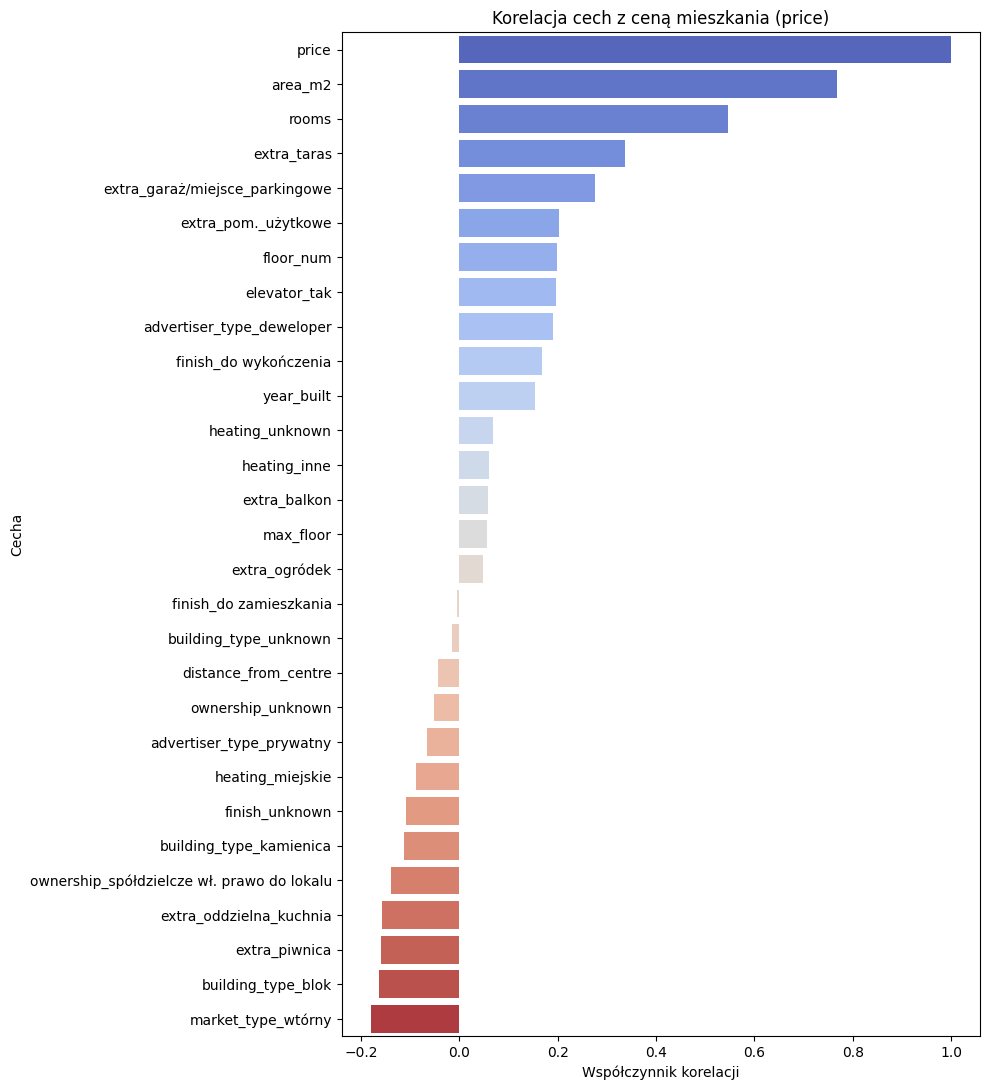

In [75]:
corr = data_encoded.corr(numeric_only=True)["price"].sort_values(ascending=False)

# # tylko cechy z korelacją istotną (> 0.1 lub < -0.1)
# corr_features = corr[abs(corr) > 0.1]

plt.figure(figsize=(10, 11))
sns.barplot(x=corr.values, y=corr.index, palette="coolwarm")
plt.title("Korelacja cech z ceną mieszkania (price)")
plt.xlabel("Współczynnik korelacji")
plt.ylabel("Cecha")
plt.tight_layout()
plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_8288\2501214682.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


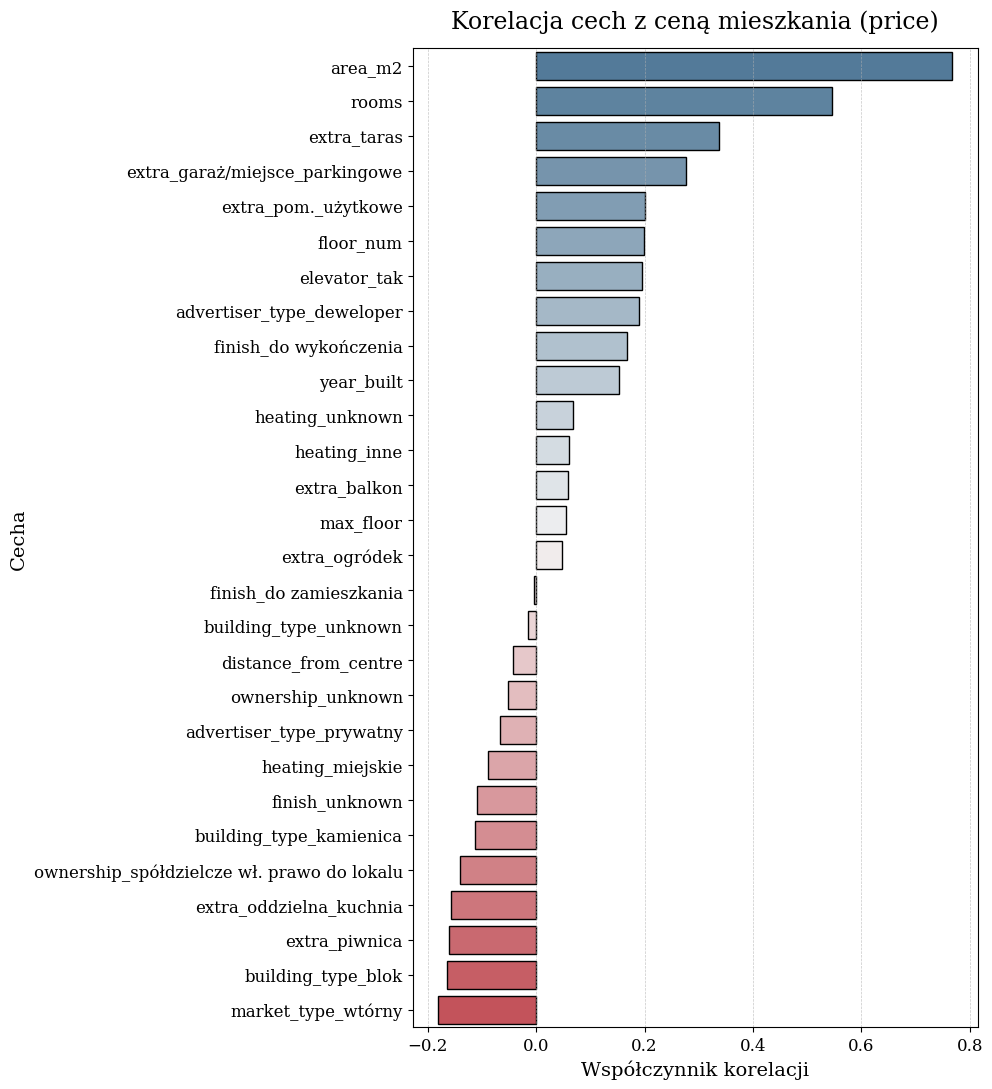

In [ ]:
mpl.rcParams['font.family'] = 'DejaVu Serif'
mpl.rcParams['axes.titlesize'] = 17
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

corr = data_encoded.corr(numeric_only=True)["price"].drop("price")

# Sortowanie od największej do najmniejszej (dodatnie u góry)
corr = corr.sort_values(ascending=False)

plt.figure(figsize=(10, 11))

sns.barplot(
    x=corr.values,
    y=corr.index,
    palette=sns.diverging_palette(240, 10, s=70, l=50, n=len(corr)),
    edgecolor='black'
)

plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7)

plt.title("Korelacja cech z ceną mieszkania (price)", pad=15)
plt.xlabel("Współczynnik korelacji")
plt.ylabel("Cecha")

plt.tight_layout()
plt.show()


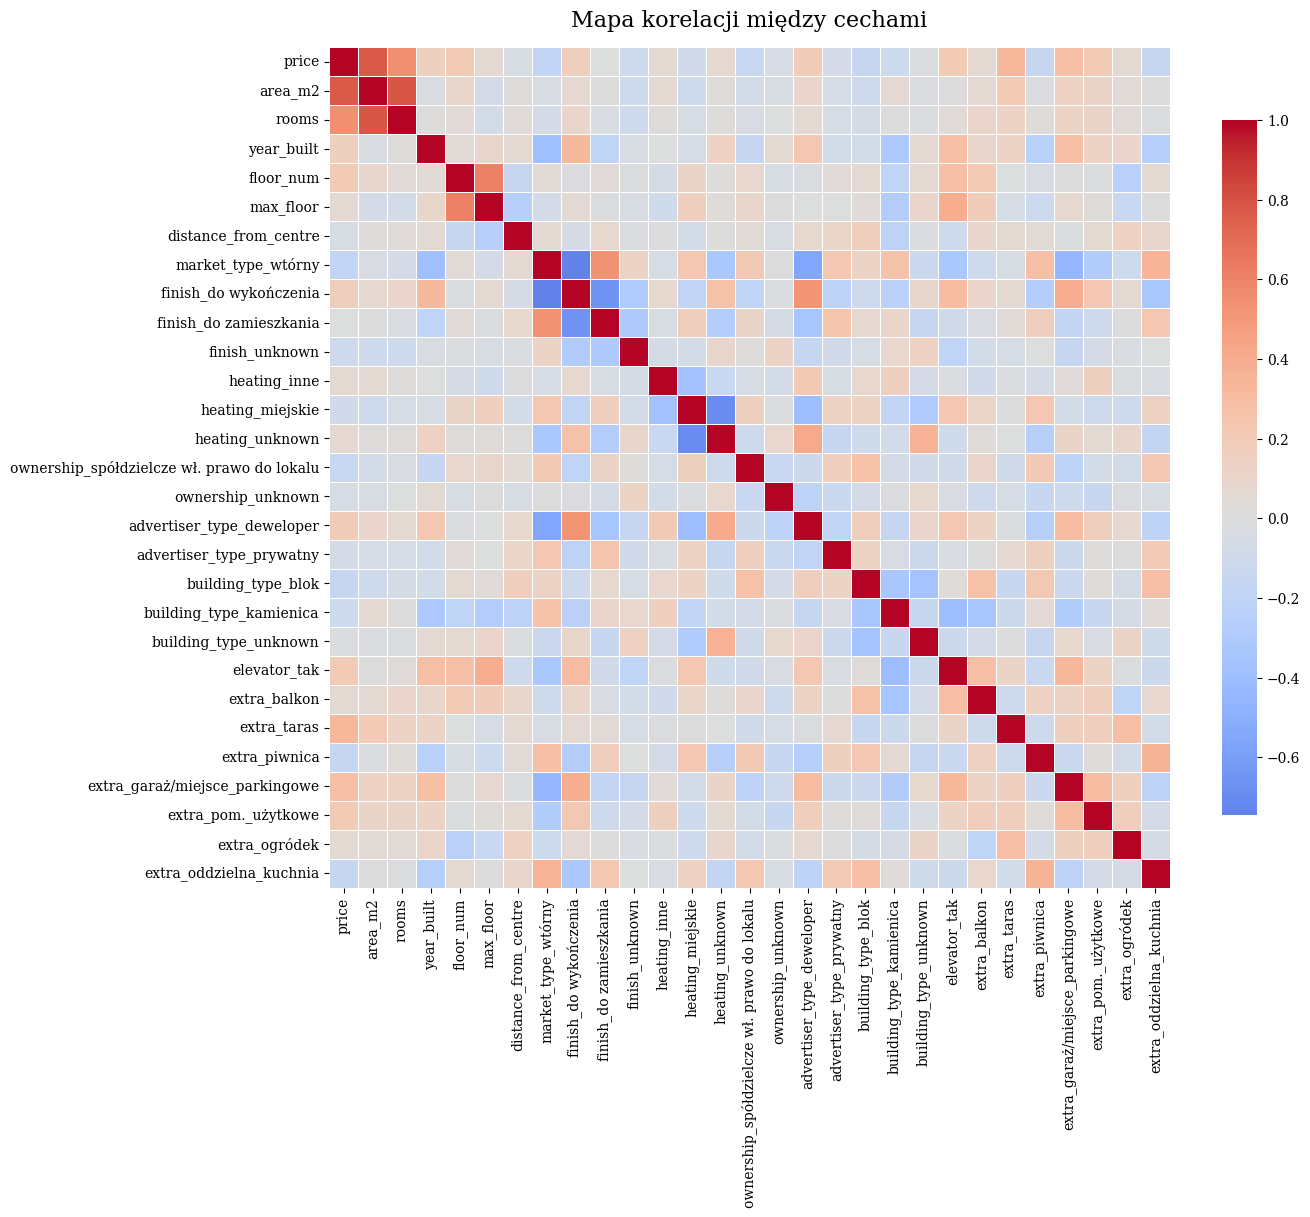

In [ ]:
mpl.rcParams['font.family'] = 'DejaVu Serif'
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

corr_matrix = data_encoded.corr(numeric_only=True)

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix, 
    cmap='coolwarm', 
    center=0,
    annot=False,      # True jeśli liczby w każdej kratce
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Mapa korelacji między cechami", pad=15)
plt.tight_layout()
plt.show()


16. Usuwanie outliers

In [76]:
Q1 = data_encoded["price"].quantile(0.25)
Q3 = data_encoded["price"].quantile(0.75)
IQR = Q3 - Q1

# Granice
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"📉 Dolna granica: {lower_bound:.0f} zł")
print(f"📈 Górna granica: {upper_bound:.0f} zł")

outliers = data_encoded[(data_encoded["price"] < lower_bound) | (data_encoded["price"] > upper_bound)]
print(f"Liczba outliersów: {len(outliers)} ({len(outliers)/len(data)*100:.2f}%)")

# Usuń outliers
data_cleaned = data_encoded[(data_encoded["price"] >= lower_bound) & (data_encoded["price"] <= upper_bound)].copy()
print(f"Zostało {len(data_cleaned)} rekordów po usunięciu outliersów.")


📉 Dolna granica: -52283 zł
📈 Górna granica: 1188591 zł
Liczba outliersów: 106 (5.93%)
Zostało 1682 rekordów po usunięciu outliersów.


In [77]:
# data_cleaned.to_csv("katowice_clean_encoded_otliers.csv", index=False, encoding="utf-8-sig")